In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor as pt
import pybaseball 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 504

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.19.1


In [2]:
from retrieve_sql_module import get_table

fangraphs_batting_stats_2024 = get_table("fangraphs_batting_stats_2024")

D:\jamin\baseball-projects\projections\hitting\scripts\retrieve_sql_module.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pbp_data = pd.concat(pbp_data_list, ignore_index=True)


In [12]:
fitting_subset = (
    fangraphs_batting_stats_2024
    .assign(
        label=lambda df: df["Name"].astype(str) + " - " + 
                         df["Season"].astype(str) + " - " + 
                         df["Team"].astype(str)
    )
)

In [13]:
fitting_subset

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label
0,15640,2024,Aaron Judge,NYY,32,158,559,704,180,85,...,238,0.609,391,0.146,0.267,0.315,0.742,0.484,11.3,Aaron Judge - 2024 - NYY
1,25764,2024,Bobby Witt Jr.,KCR,24,161,636,709,211,123,...,259,0.481,538,0.138,0.236,0.321,0.594,0.413,10.0,Bobby Witt Jr. - 2024 - KCR
2,19755,2024,Shohei Ohtani,LAD,29,159,636,731,197,98,...,287,0.595,482,0.144,0.269,0.320,0.678,0.448,9.0,Shohei Ohtani - 2024 - LAD
3,20123,2024,Juan Soto,NYY,25,157,576,713,166,90,...,262,0.568,461,0.189,0.263,0.319,0.658,0.463,8.2,Juan Soto - 2024 - NYY
4,26289,2024,Gunnar Henderson,BAL,23,159,630,719,177,102,...,256,0.539,475,0.167,0.265,0.289,0.505,0.379,7.7,Gunnar Henderson - 2024 - BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,6887,2024,Martin Maldonado,CHW,37,48,135,147,16,9,...,31,0.356,87,0.194,0.360,0.160,0.295,0.223,-1.3,Martin Maldonado - 2024 - CHW
636,15676,2024,Jose Abreu,HOU,37,35,113,120,14,10,...,28,0.326,86,0.173,0.298,0.162,0.241,0.199,-1.5,Jose Abreu - 2024 - HOU
637,20543,2024,Elehuris Montero,COL,25,67,224,247,46,32,...,71,0.415,171,0.132,0.290,0.212,0.338,0.274,-1.8,Elehuris Montero - 2024 - COL
638,12155,2024,Eddie Rosario,- - -,32,91,297,319,52,30,...,96,0.425,226,0.146,0.281,0.212,0.345,0.259,-2.3,Eddie Rosario - 2024 - - - -


In [14]:
fitting_subset['hr_rate'] = fitting_subset['HR'] / fitting_subset['PA']

In [15]:
fitting_subset.sort_values(by="hr_rate", ascending = False).head(5)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label,hr_rate
305,19273,2024,Stone Garrett,WSN,28,2,5,6,3,1,...,0.800,5,0.032,0.129,0.602,1.390,0.799,0.3,Stone Garrett - 2024 - WSN,0.166667
349,25448,2024,Greg Jones,COL,26,6,5,6,1,0,...,1.000,1,0.103,0.310,0.199,0.791,0.448,0.1,Greg Jones - 2024 - COL,0.166667
294,25705,2024,Dustin Harris,TEX,24,2,6,7,2,0,...,0.750,4,0.174,0.304,0.285,0.512,0.385,0.2,Dustin Harris - 2024 - TEX,0.142857
426,19928,2024,Ryan McKenna,- - -,27,13,14,15,3,1,...,0.444,9,0.115,0.212,0.169,0.383,0.260,-0.1,Ryan McKenna - 2024 - - - -,0.133333
239,27493,2024,Rece Hinds,CIN,23,24,46,51,12,2,...,0.400,30,0.114,0.310,0.254,0.625,0.396,0.6,Rece Hinds - 2024 - CIN,0.098039


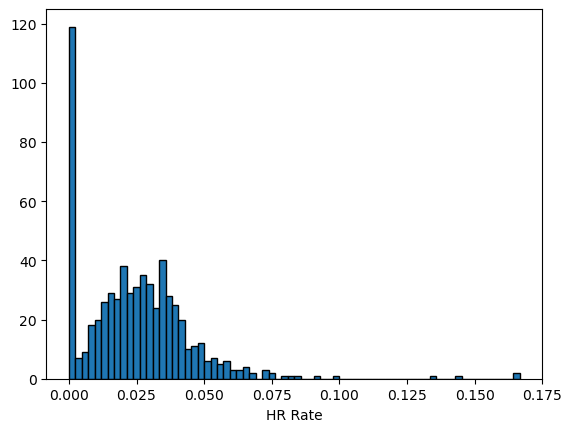

In [16]:
plt.hist(fitting_subset['hr_rate'].dropna(), bins = 70, edgecolor='black')
plt.xlabel("HR Rate")
plt.show()

In [50]:
pa, hr = fitting_subset[["PA", "HR"]].astype(np.int32).to_numpy().T
coords = {"batter":fitting_subset[['label']].to_numpy().squeeze()}

Uninformative model with p modeled as a uniform probability
$$
p_i \sim \text{Uniform}(0,1)
$$

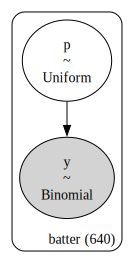

In [51]:
with pm.Model(coords=coords) as uninformative_prior_model:

    p = pm.Uniform("p", 0, 1, dims = "batter")

    y = pm.Binomial("y", n = pa, p = p, observed = hr, dims="batter")
pm.model_to_graphviz(uninformative_prior_model)

In [52]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


In [53]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

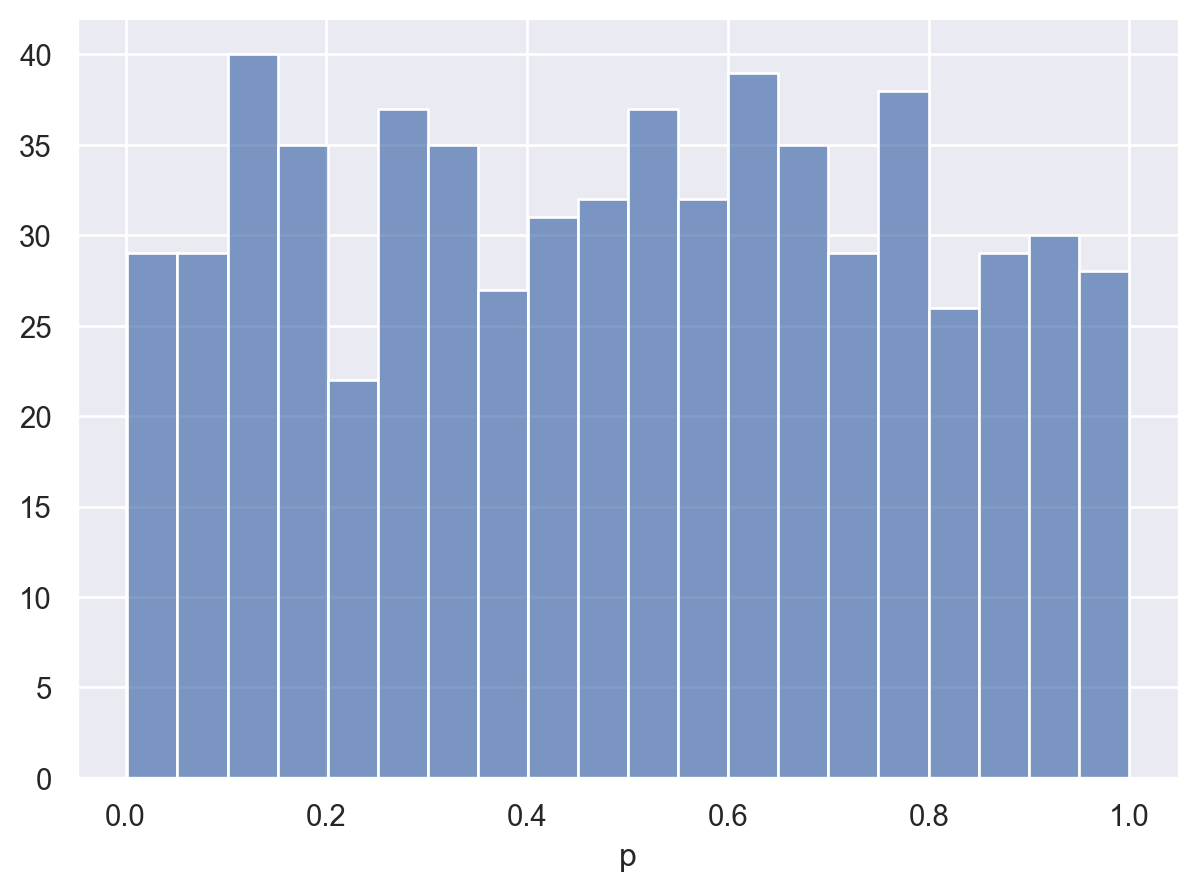

In [54]:
so.Plot(uninformed_prior_trace.prior['p'].sel(chain=[0], draw = [0]).squeeze()).add(so.Bars(), so.Hist(bins = 20))

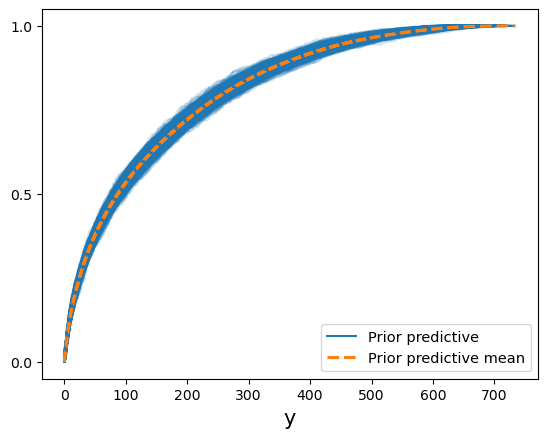

In [55]:
az.plot_ppc(uninformed_prior_trace, group = 'prior', kind = 'cumulative');

In [56]:
with uninformative_prior_model:
    trace = pm.sample(draws=100,tune = 100,cores =4, chains = 4, random_seed = RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [57]:
az.summary(trace).sort_values("r_hat", ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[Jack Suwinski - 2024 - PIT],0.036,0.011,0.018,0.057,0.000,0.000,528.0,305.0,1.07
p[Adolis Garcia - 2024 - TEX],0.040,0.008,0.026,0.055,0.000,0.000,437.0,149.0,1.06
p[Paul DeJong - 2024 - - - -],0.052,0.010,0.037,0.072,0.001,0.000,318.0,139.0,1.06
p[Tyler O'Neill - 2024 - BOS],0.068,0.012,0.046,0.091,0.001,0.000,419.0,284.0,1.05
p[David Dahl - 2024 - PHI],0.063,0.030,0.017,0.122,0.002,0.001,332.0,169.0,1.05


In [58]:
with uninformative_prior_model:
    trace = pm.sample(draws = 1000, tune = 1000, cores = 4, chains = 4, random_seed = RANDOM_SEED)
uninformed_prior_trace.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<Axes: title={'center': 'p\nMookie Betts - 2024 - LAD'}, xlabel='Total number of draws', ylabel='ESS'>

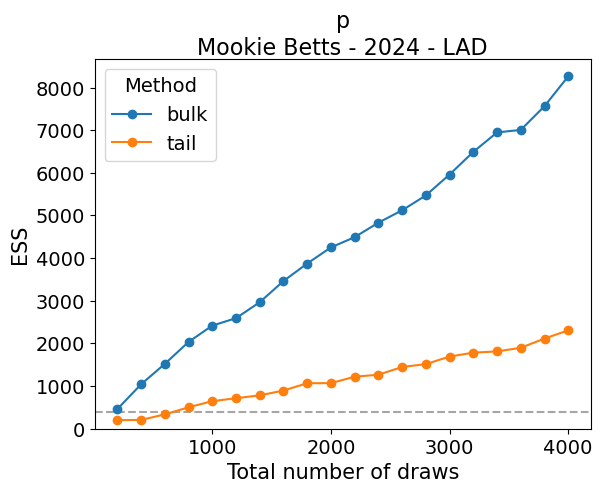

In [29]:
az.plot_ess(uninformed_prior_trace, var_names=["p"], coords ={"batter":["Mookie Betts - 2024 - LAD"]}, kind = "evolution")

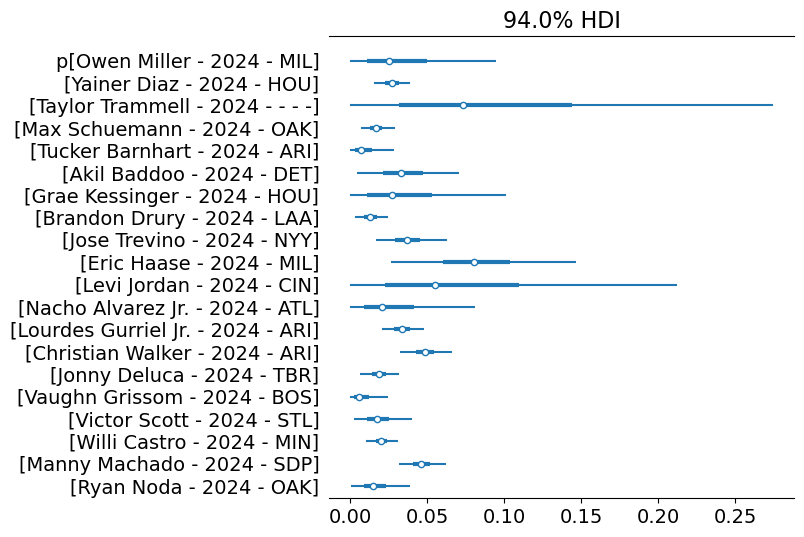

In [70]:
sampled_batters = fitting_subset.sample(n=20, random_state = 25555)

selected_data = sampled_batters[['label','hr_rate']]

SAMPLE_BATTERS,obs_rates = selected_data.to_numpy().T

(ax,) = az.plot_forest(uninformed_prior_trace, coords = {"batter":list(SAMPLE_BATTERS)}, combined = True)

In [36]:
uninformed_means = uninformed_prior_trace.posterior.mean(dim=("chain","draw"))
uninformed_hdi = az.hdi(uninformed_prior_trace)

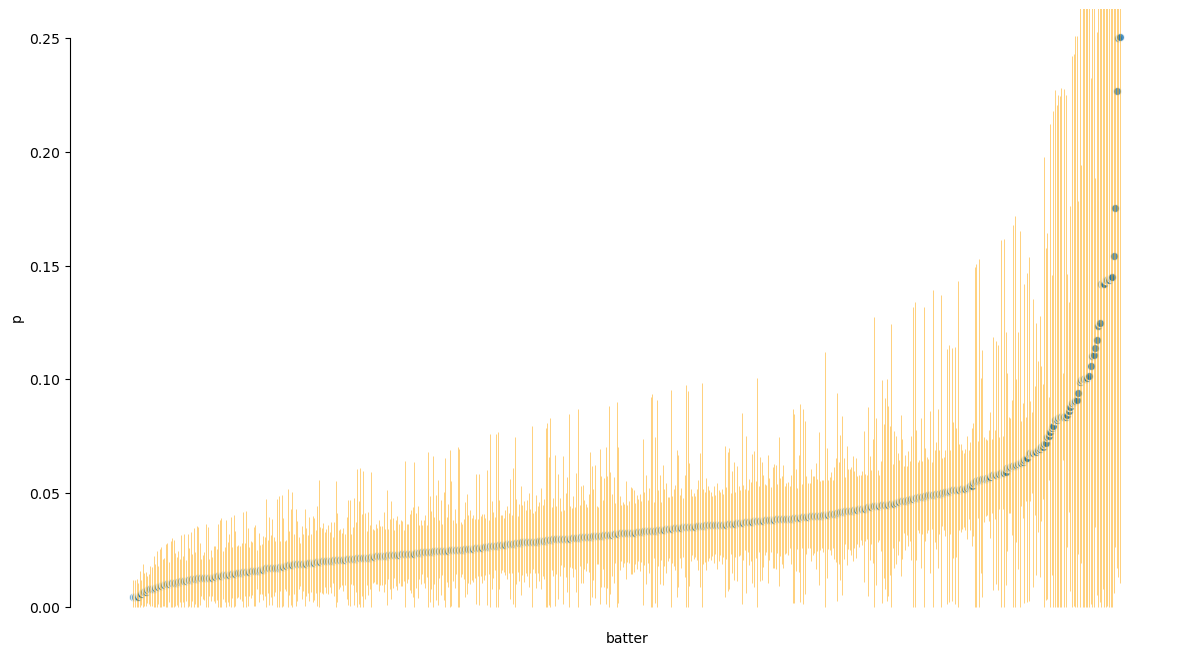

In [41]:
fig, ax = plt.subplots(figsize=(14,8))

uninformed_means_iter = uninformed_means.sortby("p")
uninformed_hdi_iter = uninformed_hdi.sortby(uninformed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    uninformed_hdi_iter.p.sel(hdi="lower"),
    uninformed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=0.6
)
uninformed_means_iter.plot.scatter(x="batter", y = "p", ax=ax, alpha = 0.8)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10,trim=True,bottom=True)

Text(0, 0.5, 'Uncertainty of estimate')

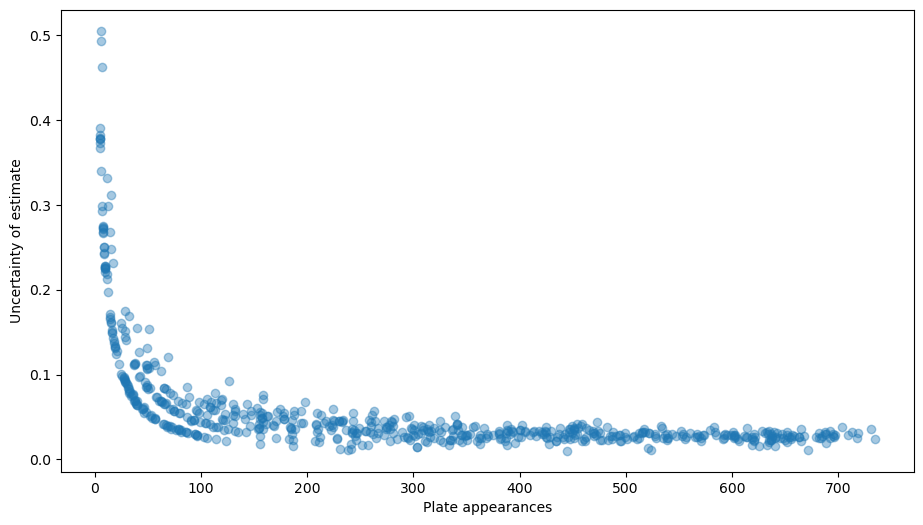

In [44]:
uncertainty = uninformed_hdi.p.sel(hdi="higher") - uninformed_hdi.p.sel(hdi = "lower")

plt.figure(figsize=(11,6))
plt.plot(pa, uncertainty, "o", alpha = 0.4)
plt.xlabel("Plate appearances")
plt.ylabel("Uncertainty of estimate")

Text(0.5, 0, 'Home Run Rate')

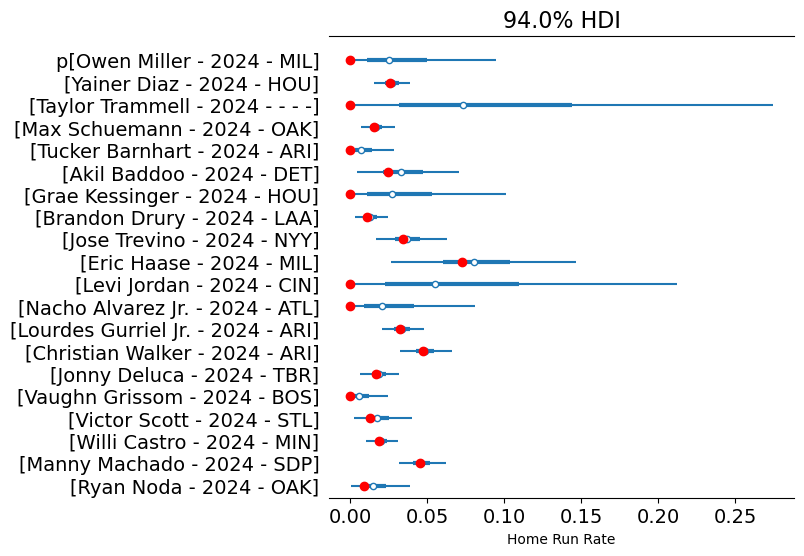

In [46]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords = {"batter":SAMPLE_BATTERS}, combined = True)
ax.plot(obs_rates[::-1], ax.get_yticks(), "ro")
ax.set_xlabel("Home Run Rate")

In [47]:
with uninformative_prior_model:
    pm.sample_posterior_predictive(uninformed_prior_trace, extend_inferencedata=True)

Sampling: [y]


array([<Axes: xlabel='y'>], dtype=object)

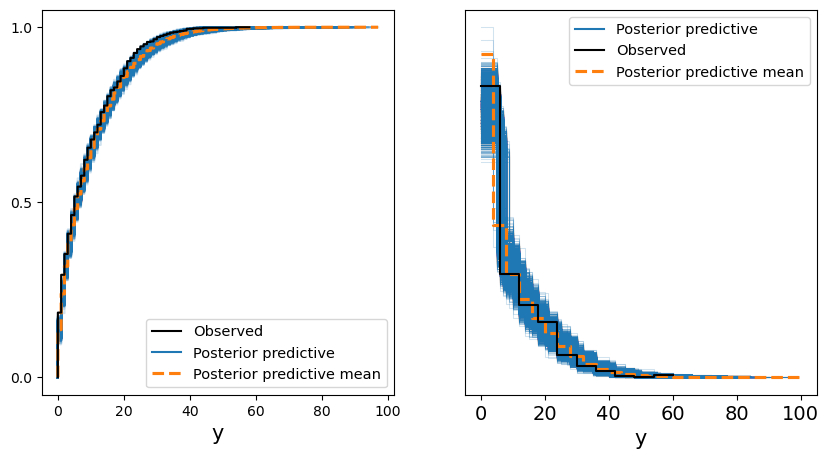

In [50]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
az.plot_ppc(uninformed_prior_trace, group = "posterior", kind = "cumulative", ax=axes[0])
az.plot_ppc(uninformed_prior_trace, group = "posterior", ax = axes[1])

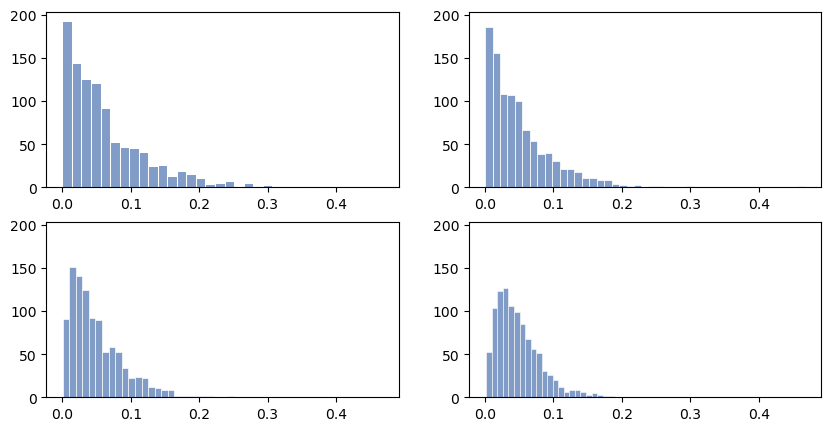

In [52]:
fig,axes = plt.subplots(2,2, figsize=(10,5), sharex=True, sharey=True)

for params, ax in zip([(1,15), (1,20), (1.5,30), (2,40)], axes.flat):
    so.Plot(pm.Beta.dist(*params, shape=1000).eval()).add(so.Bars(), so.Hist()).on(ax).plot()

In [53]:
pm.find_constrained_prior(
    pm.Beta,
    lower=0.01,
    upper=0.11,
    init_guess={"alpha" : 2, "beta" : 40}
)

C:\Users\jamin\AppData\Local\Temp\ipykernel_33452\1056268626.py:1: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  pm.find_constrained_prior(


{'alpha': 3.1375906600927745, 'beta': 60.55565032508642}

C:\Users\jamin\AppData\Local\Temp\ipykernel_33452\214001403.py:2: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  beta_params = pm.find_constrained_prior(


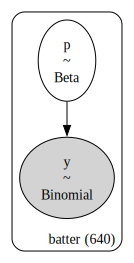

In [56]:
with pm.Model(coords=coords) as informative_prior_model:
    beta_params = pm.find_constrained_prior(
        pm.Beta,
        lower=0.05,
        upper=0.09,
        init_guess={"alpha": 2, "beta" : 40},
    )

    p = pm.Beta("p", **beta_params, dims="batter")

    y = pm.Binomial("y", n = pa, p = p, observed=hr, dims = "batter")

pm.model_to_graphviz(informative_prior_model)

In [57]:
with informative_prior_model:
    informed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


<Axes: xlabel='y'>

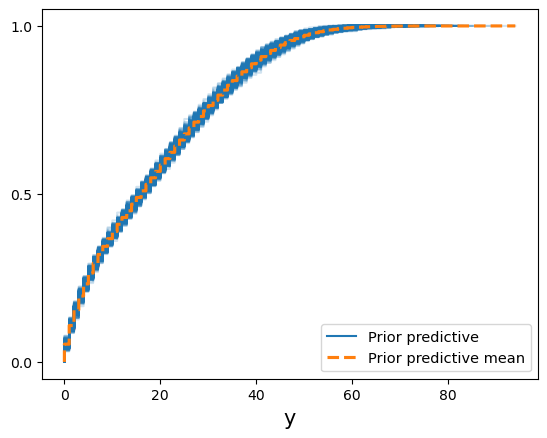

In [58]:
az.plot_ppc(informed_prior_trace, group = "prior", kind = "cumulative")

In [60]:
with informative_prior_model:
    informed_prior_trace.extend(pm.sample(cores=4, chains=4, random_seed = RANDOM_SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [62]:
informed_means = informed_prior_trace.posterior.mean(dim=("chain","draw"))
informed_hdi = az.hdi(informed_prior_trace)

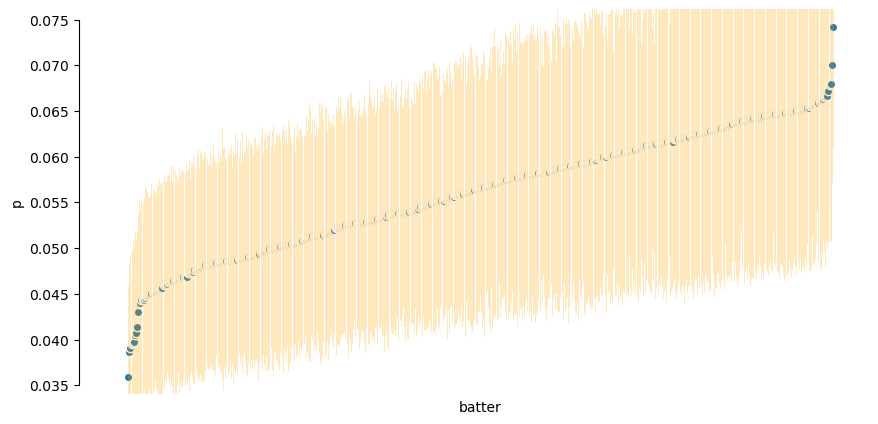

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

informed_means_iter = informed_means.sortby("p")
informed_hdi_iter = informed_hdi.sortby(informed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    informed_hdi_iter.p.sel(hdi="lower"),
    informed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.3,
    linewidth=0.6
)
informed_means_iter.plot.scatter(x="batter", y = "p", ax=ax)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True)

Partial pooling model

C:\Users\jamin\AppData\Local\Temp\ipykernel_9464\3268792505.py:7: RuntimeWarning: divide by zero encountered in divide
  partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1 / var_rates + 1 /pop_var)
C:\Users\jamin\AppData\Local\Temp\ipykernel_9464\3268792505.py:7: RuntimeWarning: invalid value encountered in multiply
  partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1 / var_rates + 1 /pop_var)


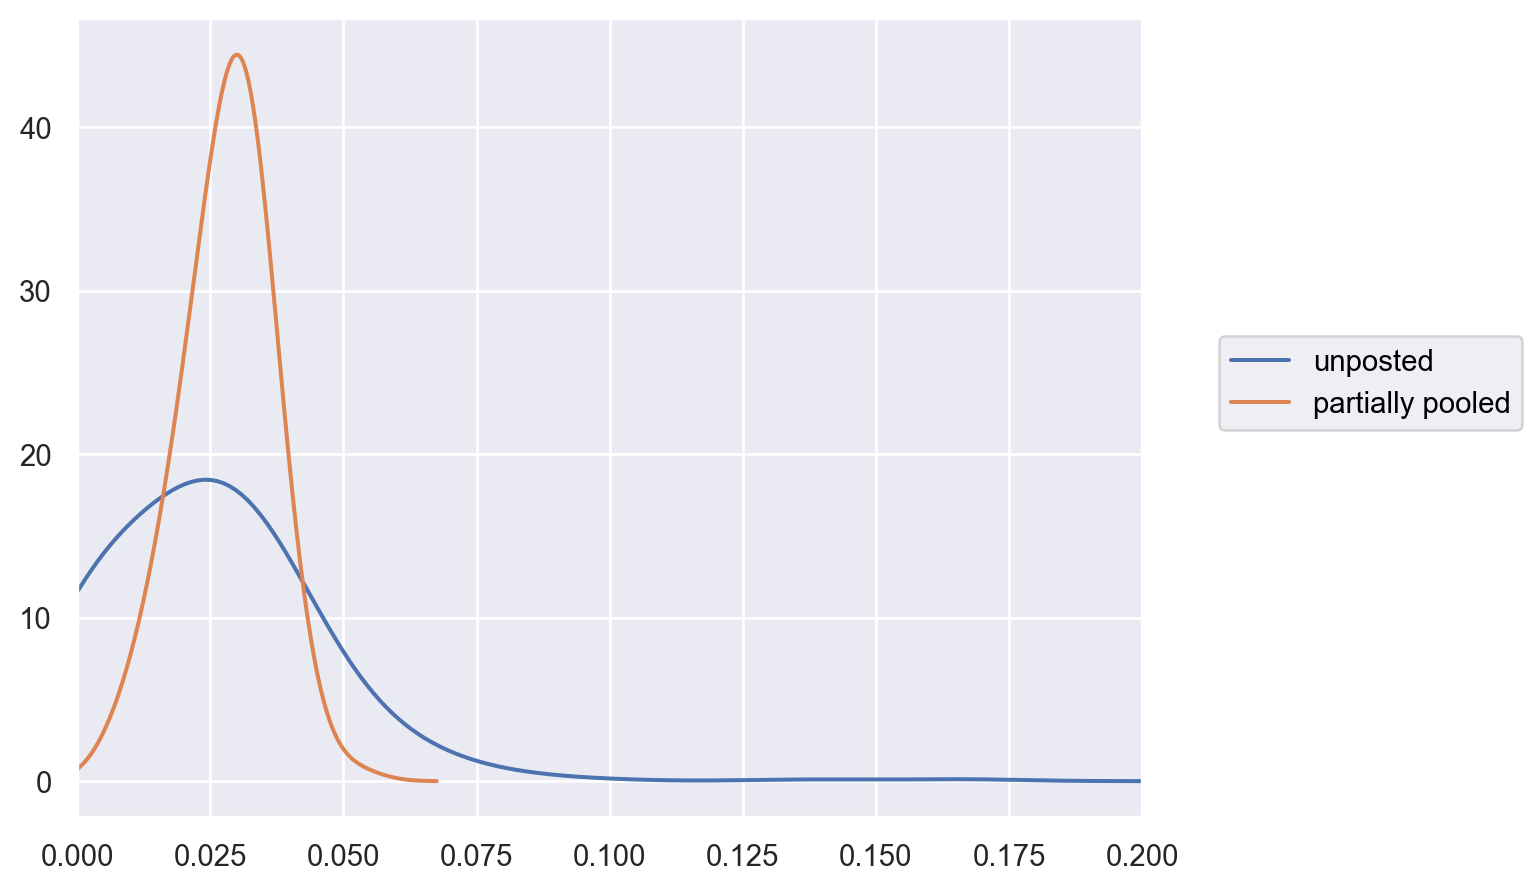

In [23]:
rates = hr / pa
var_rates = rates * (1 - rates)

pop_rate = (fitting_subset["HR"].sum() / fitting_subset["PA"].sum())
pop_var = pop_rate * (1 - pop_rate)

partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1 / var_rates + 1 /pop_var)

(
    so.Plot()
    .add(so.Line(color="C0"), so.KDE(bw_adjust=2), x=rates, label = "unpooled")
    .add(so.Line(color="C1"), so.KDE(bw_adjust=2), x=partial_pooled_rates, label="partially pooled")
    .limit(x=(0,0.2))
)

$$
p_i \sim Beta(\alpha, \beta)
$$

In [26]:
def factorize(dataset, col_name):
    dataset["idx"] = dataset[col_name].astype("category").cat.codes
    categories = dataset[[col_name, "idx"]].drop_duplicates().sort_values("idx")[col_name].to_numpy()
    idx = dataset["idx"].to_numpy()

    return idx, categories

batter_idx, batters = factorize(fitting_subset, "Name")
obs_idx, observations = factorize(fitting_subset, "label")

coords = {"batter" : batters, "obs" : observations}

In [32]:
batters

array(['Aaron Hicks', 'Aaron Judge', 'Aaron Schunk', 'Abraham Toro',
       'Adael Amador', 'Adam Duvall', 'Adam Frazier', 'Addison Barger',
       'Adley Rutschman', 'Adolis Garcia', 'Adrian Del Castillo',
       'Akil Baddoo', 'Alan Trejo', 'Alec Bohm', 'Alec Burleson',
       'Aledmys Diaz', 'Alejandro Kirk', 'Alek Thomas', 'Alex Bregman',
       'Alex Call', 'Alex Jackson', 'Alex Kirilloff', 'Alex Verdugo',
       'Alexander Canario', 'Ali Sanchez', 'Alika Williams',
       'Amed Rosario', 'Andres Chaparro', 'Andres Gimenez',
       'Andrew Benintendi', 'Andrew Knapp', 'Andrew Knizner',
       'Andrew McCutchen', 'Andrew Vaughn', 'Andruw Monasterio',
       'Andy Ibanez', 'Andy Pages', 'Angel Martinez', 'Anthony Rendon',
       'Anthony Rizzo', 'Anthony Santander', 'Anthony Volpe',
       'Aramis Garcia', 'Armando Alvarez', 'Austin Barnes', 'Austin Hays',
       'Austin Hedges', 'Austin Martin', 'Austin Riley', 'Austin Shenton',
       'Austin Slater', 'Austin Wells', 'Austin Wynns

In [27]:
with pm.Model(coords=coords) as beta_partial_pooling_model:
    alpha_params = pm.find_constrained_prior(
        pm.Gamma,
        lower=0.05,
        upper=2,
        init_guess={"alpha": 2, "beta": 1},
    )
    alpha = pm.Gamma("alpha", **alpha_params)

    beta_params = pm.find_constrained_prior(
        pm.Gamma,
        lower=8,
        upper=12,
        init_guess={"alpha": 10, "beta": 1},
    )
    beta = pm.Gamma("beta", **beta_params)

C:\Users\jamin\AppData\Local\Temp\ipykernel_9464\503390301.py:2: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  alpha_params = pm.find_constrained_prior(
C:\Users\jamin\AppData\Local\Temp\ipykernel_9464\503390301.py:10: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  beta_params = pm.find_constrained_prior(


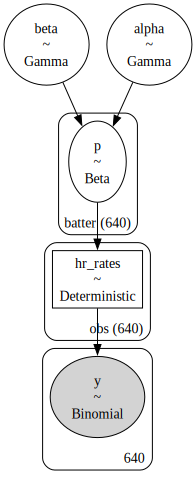

In [28]:
with beta_partial_pooling_model:

    p = pm.Beta("p", alpha, beta, dims = "batter")

    hr_rates = pm.Deterministic("hr_rates", p[batter_idx], dims = "obs")

    y = pm.Binomial("y", n = pa, p = hr_rates, observed = hr)

pm.model_to_graphviz(beta_partial_pooling_model)

Sampling: [alpha, beta, p, y]


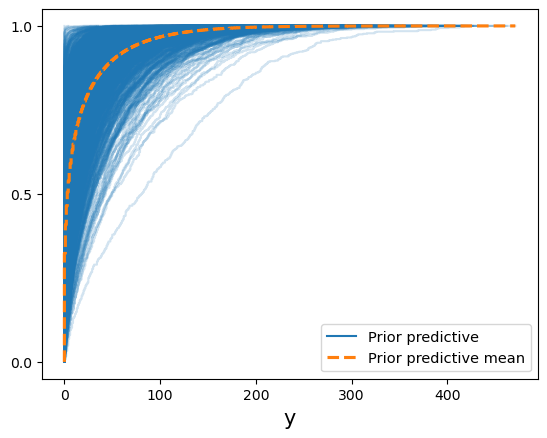

In [33]:
with beta_partial_pooling_model:
    beta_partial_pooling_trace = pm.sample_prior_predictive(1000)

az.plot_ppc(beta_partial_pooling_trace, group="prior", kind="cumulative");

In [34]:
with beta_partial_pooling_model:
    beta_partial_pooling_trace.extend(pm.sample(chains=4, cores=4, random_seed=RANDOM_SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [36]:
with beta_partial_pooling_model:
    pm.sample_posterior_predictive(beta_partial_pooling_trace, extend_inferencedata=True)

Sampling: [y]


array([<Axes: xlabel='y'>], dtype=object)

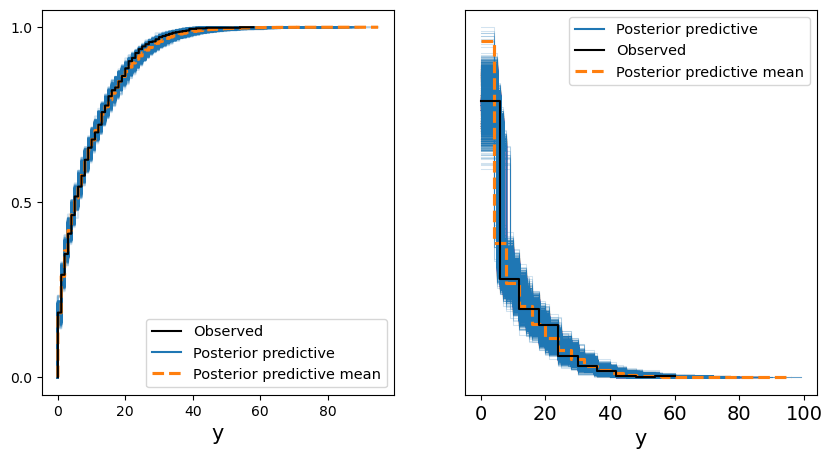

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
az.plot_ppc(beta_partial_pooling_trace, group = "posterior", kind = "cumulative", ax=axes[0])
az.plot_ppc(beta_partial_pooling_trace, group = "posterior", ax = axes[1])

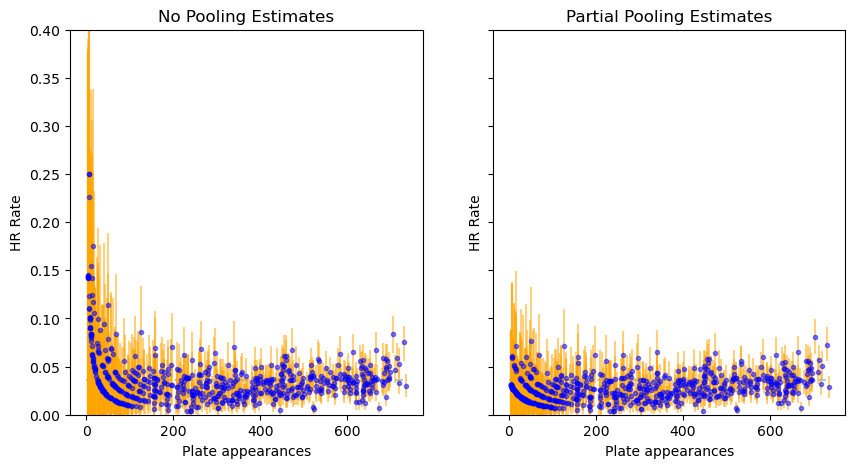

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

N_pa = fitting_subset["PA"].to_numpy().squeeze()
for ax, trace, level, idx in zip(
    axes,
    (uninformed_prior_trace, beta_partial_pooling_trace),
    ("no pooling", "partial pooling"),
    (slice(0, len(N_pa)), batter_idx)
):
    alpha = beta_partial_pooling_trace.posterior.alpha.mean()
    beta = beta_partial_pooling_trace.posterior.beta.mean()
    ax.hlines(
        alpha / (alpha + beta),
        0.,
        N_pa.max() + 1,
        alpha = 0.4,
        ls="--",
        label = "Est. population mean",
    )

    hdi = az.hdi(trace).p[idx]
    ax.vlines(N_pa, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color = "orange", alpha=0.5)

    ax.plot(
        N_pa,
        trace.posterior.mean(dim=("chain","draw")).p[idx],
        "b.", alpha=0.5
    )

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Plate appearances",
        ylabel="HR Rate",
        ylim=(0,0.4)
    )
        

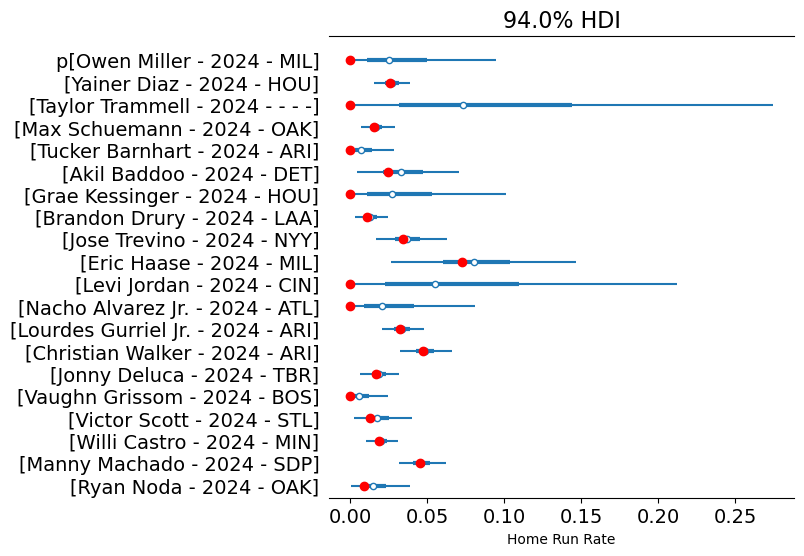

In [71]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords={"batter": list(SAMPLE_BATTERS)}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(), "ro")
ax.set_xlabel("Home Run Rate");
xlim = ax.get_xlim();

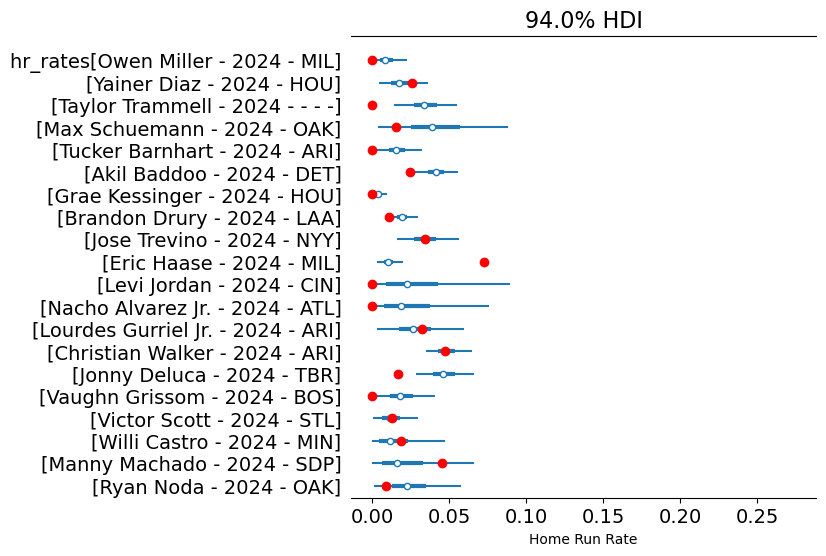

In [73]:
(ax,) = az.plot_forest(beta_partial_pooling_trace.posterior["hr_rates"], coords={"obs": SAMPLE_BATTERS}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(),"ro")
ax.set_xlabel("Home Run Rate")
ax.set_xlim(xlim);

## Group Covariate Model ##

$$
logit(p_i) \sim N(\theta_i,\sigma^2)
$$

$$
\theta_i = \mu_j[i] + \epsilon_i
$$

$$
\mu \sim N(m_\mu, s_\mu), \epsilon_i ~ N(0, \sigma)
$$

Where j corresponds the the group, position, that batter i belongs to

In [75]:
position_idx, position = factorize(fitting_subset, "position")

coords["position"] = positions

with pm.Model(coords=coords) as position_means_model:
    m_mu = pm.Normal("m_mu", mu=-2, sigma=1)
    s_mu = pm.HalfNormal("s_mu", 1)
    mu = pm.Normal("mu", m=m_mu, sigma=s_mu, dims="batter")

    sigma = pm.HalfNormal("sigma", 1)
    epsilon = pm.Normal("epsilon", mu=0, sigma=sigma, dims = "batter")

    p = pm.Deterministic("p", pm.math.invlogit(mu[position_idx] + epsilon[batter_idx]), dims="obs")

    y = pm.Binomial("y", n=pa, p=p, observed=hr)

pm.model_to_graphviz(position_means_model)
    

KeyError: 'position'

In [77]:
fitting_subset

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label,hr_rate,idx
0,15640,2024,Aaron Judge,NYY,32,158,559,704,180,85,...,391,0.146,0.267,0.315,0.742,0.484,11.3,Aaron Judge - 2024 - NYY,0.082386,1
1,25764,2024,Bobby Witt Jr.,KCR,24,161,636,709,211,123,...,538,0.138,0.236,0.321,0.594,0.413,10.0,Bobby Witt Jr. - 2024 - KCR,0.045134,67
2,19755,2024,Shohei Ohtani,LAD,29,159,636,731,197,98,...,482,0.144,0.269,0.320,0.678,0.448,9.0,Shohei Ohtani - 2024 - LAD,0.073871,552
3,20123,2024,Juan Soto,NYY,25,157,576,713,166,90,...,461,0.189,0.263,0.319,0.658,0.463,8.2,Juan Soto - 2024 - NYY,0.057504,350
4,26289,2024,Gunnar Henderson,BAL,23,159,630,719,177,102,...,475,0.167,0.265,0.289,0.505,0.379,7.7,Gunnar Henderson - 2024 - BAL,0.051460,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,6887,2024,Martin Maldonado,CHW,37,48,135,147,16,9,...,87,0.194,0.360,0.160,0.295,0.223,-1.3,Martin Maldonado - 2024 - CHW,0.027211,420
636,15676,2024,Jose Abreu,HOU,37,35,113,120,14,10,...,86,0.173,0.298,0.162,0.241,0.199,-1.5,Jose Abreu - 2024 - HOU,0.016667,331
637,20543,2024,Elehuris Montero,COL,25,67,224,247,46,32,...,171,0.132,0.290,0.212,0.338,0.274,-1.8,Elehuris Montero - 2024 - COL,0.016194,190
638,12155,2024,Eddie Rosario,- - -,32,91,297,319,52,30,...,226,0.146,0.281,0.212,0.345,0.259,-2.3,Eddie Rosario - 2024 - - - -,0.031348,182


In [90]:
from pybaseball import chadwick_register
from 
data = chadwick_register()

Gathering player lookup table. This may take a moment.


In [91]:
data

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,Bradley,Jed,605152,bradj002,bradlje01,13166,2016.0,2016.0
1,Barrios,Manuel,110625,barrm002,barrima01,1000605,1997.0,1998.0
2,Martin,Frank,118336,martf102,martifr01,1008165,1897.0,1899.0
3,Browne,Byron,111603,browb101,brownby01,1001500,1965.0,1972.0
4,Jackson,John,800935,jackj702,NaN,-1,NaN,NaN
...,...,...,...,...,...,...,...,...
25637,Page,Vance,120175,pagev101,pageva01,1009957,1938.0,1941.0
25638,Wilkinson,Roy,124274,wilkr101,wilkiro01,1013961,1918.0,1922.0
25639,Demaree,Al,113250,demaa101,demaral01,1003187,1912.0,1919.0
25640,McKee,Frank,118767,mckef101,mckeefr01,1008583,1884.0,1884.0


In [83]:
from pybaseball import statcast_outs_above_average
data = statcast_outs_above_average(2024,)

TypeError: statcast_outs_above_average() missing 1 required positional argument: 'pos'

In [89]:
pybaseball.batting_stats(2024,position="CF")

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
0,15640,2024,Aaron Judge,NYY,32,158,559,704,180,85,...,117.5,238,0.609,391,0.146,0.267,0.315,0.742,0.484,11.3
1,24617,2024,Jarren Duran,BOS,27,160,671,735,191,108,...,113.9,225,0.437,515,0.161,0.266,0.280,0.464,0.346,6.2
2,29490,2024,Jackson Merrill,SDP,21,156,554,593,162,101,...,111.6,203,0.439,462,0.102,0.210,0.308,0.547,0.376,5.2
4,29591,2024,Colton Cowser,BAL,24,153,499,561,121,70,...,113.6,149,0.452,330,0.188,0.316,0.234,0.449,0.331,3.4
7,20454,2024,Jazz Chisholm Jr.,- - -,26,147,562,621,144,95,...,110.1,168,0.408,412,0.153,0.279,0.242,0.423,0.318,3.5
8,25878,2024,Corbin Carroll,ARI,23,158,589,684,136,78,...,111.5,191,0.406,471,0.194,0.269,0.247,0.403,0.329,3.6
10,23697,2024,Julio Rodriguez,SEA,23,143,567,613,155,118,...,114.5,199,0.482,413,0.114,0.269,0.279,0.472,0.346,3.7
6,25479,2024,Brenton Doyle,COL,26,149,542,603,141,90,...,110.1,164,0.409,401,0.135,0.274,0.259,0.448,0.333,3.3
13,19918,2024,Daulton Varsho,TOR,27,136,459,513,98,52,...,110.2,108,0.333,324,0.157,0.270,0.189,0.325,0.265,3.3
5,26368,2024,J.J. Bleday,OAK,26,159,572,642,139,72,...,113.3,162,0.362,448,0.164,0.270,0.244,0.404,0.319,3.3


In [82]:
data

,"last_name, first_name",player_id,display_team_name,year,primary_pos_formatted,fielding_runs_prevented,outs_above_average,outs_above_average_infront,outs_above_average_lateral_toward3bline,outs_above_average_lateral_toward1bline,outs_above_average_behind,outs_above_average_rhh,outs_above_average_lhh,actual_success_rate_formatted,adj_estimated_success_rate_formatted,diff_success_rate_formatted
0,"Bader, Harrison",664056,Mets,2024,CF,9,10,1,4,5,0,7,3,94%,91%,3%
1,"Bellinger, Cody",641355,Cubs,2024,CF,0,0,0,0,0,0,0,-1,89%,89%,0%
2,"Bleday, JJ",668709,Athletics,2024,CF,-3,-3,-4,0,1,0,-1,-3,90%,91%,-1%
3,"Buxton, Byron",621439,Twins,2024,CF,2,3,-1,-1,4,0,3,0,88%,87%,1%
4,"Carroll, Corbin",682998,D-backs,2024,CF,2,3,0,2,1,-1,1,2,89%,88%,1%
5,"Chisholm Jr., Jazz",665862,---,2024,CF,1,1,0,0,2,-1,-1,2,90%,89%,1%
6,"Crow-Armstrong, Pete",691718,Cubs,2024,CF,13,14,-1,5,10,0,7,8,94%,90%,4%
7,"Doyle, Brenton",686668,Rockies,2024,CF,14,16,1,4,6,5,9,7,93%,90%,3%
8,"Duran, Jarren",680776,Red Sox,2024,CF,7,7,1,4,3,-1,2,6,93%,90%,3%
9,"Fairchild, Stuart",656413,Reds,2024,CF,1,1,-1,1,1,1,0,1,91%,90%,1%
